### Import neccessary libraries

In [7]:
import os 
import cv2
import torch
from torch.utils.data import DataLoader , Dataset 
from torchvision import transforms
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Read dataset 

In [8]:
current_directory = os.getcwd()
os.chdir(current_directory)
datapath = r'Dataset\Pistachio_Image_Dataset\Pistachio_Image_Dataset'
subfolder = os.listdir(datapath)

images = []
labels = []
for sub in subfolder:
    label = subfolder.index(sub)
    path = os.path.join(datapath,sub)
    for img_path in os.listdir(path):
        image = cv2.imread(os.path.join(path,img_path))
        images.append(image)
        labels.append(label)

### Prepare data for training

In [9]:
class Dataprep(Dataset):
    def __init__(self, features, labels, transforms=None):
        """
        Initialize the Dataprep dataset.

        Args:
            features (list): List of input data (e.g., images).
            labels (list): List of corresponding labels for the input data.
            transforms (callable, optional): Optional transforms to be applied to the input data. Defaults to None.
        """
        self.features = features  
        self.labels = labels  
        self.transforms = transforms  
    
    def __getitem__(self, index):
        """
        Get a sample from the dataset at the specified index.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the input data and its corresponding label.
        """
        image = self.features[index]  
        label = self.labels[index]  
        if self.transforms:  
            image = self.transforms(image)  

        return image, label  
    
    def __len__(self):
        """
        Get the total number of samples in the dataset.

        Returns:
            int: Total number of samples in the dataset.
        """
        return len(self.labels)  

In [10]:
data_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((200,200))])
dataset = Dataprep(images,labels,data_transforms)
# data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
# data_sample = next(iter(data_loader))

In [11]:
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=42)
# X_test, X_val = train_test_split(X_test_val, test_size=0.5, random_state=42)
train_loader = DataLoader(X_train, batch_size=128, shuffle=True)
test_loader = DataLoader(X_test, batch_size=32, shuffle=True)
# val_loader = DataLoader(X_val, batch_size=32, shuffle=True)

### Train the model

In [12]:
class Pistachiomodel(nn.Module):
    def __init__(self):
        """
        Initialize the Pistachiomodel neural network architecture.
        """
        super(Pistachiomodel, self).__init__()
        
        # Define the layers of the neural network
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=2, stride=2, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.linear = nn.Linear(64*50*50, 2)  # Output layer with 2 classes

    def forward(self, data):
        """
        Define the forward pass of the neural network.

        Args:
            data (torch.Tensor): Input data to the neural network.

        Returns:
            torch.Tensor: Output of the neural network.
        """
        # Forward pass through the network layers
        data = self.conv1(data)  # Apply convolutional layer
        data = self.maxpool(data)  # Apply max pooling layer
        data = self.activation(data)  # Apply ReLU activation function
        data = self.flatten(data)  # Flatten the data
        data = self.dropout(data)  # Apply dropout regularization
        data = self.linear(data)  # Apply fully connected layer

        return data  # Return the output of the neural network

# Move model to device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the Pistachiomodel neural network
model = Pistachiomodel().to(device)

In [13]:
# Define the learning rate and number of epochs
learning_rate = 0.001
epochs = 50

# Define the optimizer and loss function
optimizer = optim.SGD(model.parameters(), learning_rate)  # Stochastic Gradient Descent optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss function

# Initialize variables to track total samples and correct predictions
total_sample = 0
total_correct = 0

loss_values = []
accuracy_values = []

# Iterate over the specified number of epochs
for i in range(epochs):
    # Iterate over batches of data in the training loader
    for image, target in train_loader:
        # Move input data and target labels to the appropriate device (GPU or CPU)
        image = image.to(device)
        target = target.to(device)
        
        # Zero the gradients accumulated in the optimizer
        optimizer.zero_grad()
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(image)
        
        # Compute predicted labels by finding the maximum value along dimension 1
        _, predicted = torch.max(output, 1)
        
        # Update total sample count and correct prediction count
        total_sample += target.size(0)
        total_correct += (predicted == target).sum().item()
        
        # Calculate the loss between the predicted outputs and target labels
        loss = criterion(output, target)
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Perform a single optimization step (parameter update)
        optimizer.step()

    # Calculate accuracy for the current epoch
    accuracy = total_correct / total_sample
    
    loss_values.append(loss.item())
    accuracy_values.append(accuracy)
    
    # Print epoch number, loss, and accuracy
    print(f'Epoch: {i+1}/{epochs} || Loss: {loss.item():.4f} || Accuracy: {accuracy:.2%}')


Epoch: 1/50 || Loss: 1.1053 || Accuracy: 49.59%
Epoch: 2/50 || Loss: 0.9088 || Accuracy: 51.31%
Epoch: 3/50 || Loss: 0.7374 || Accuracy: 55.06%
Epoch: 4/50 || Loss: 0.3702 || Accuracy: 60.24%
Epoch: 5/50 || Loss: 0.7445 || Accuracy: 62.61%
Epoch: 6/50 || Loss: 0.3700 || Accuracy: 65.58%
Epoch: 7/50 || Loss: 0.4671 || Accuracy: 67.79%
Epoch: 8/50 || Loss: 0.4800 || Accuracy: 69.00%
Epoch: 9/50 || Loss: 0.3362 || Accuracy: 70.41%
Epoch: 10/50 || Loss: 0.3103 || Accuracy: 71.70%
Epoch: 11/50 || Loss: 0.4867 || Accuracy: 72.72%
Epoch: 12/50 || Loss: 0.3718 || Accuracy: 73.63%
Epoch: 13/50 || Loss: 0.3918 || Accuracy: 74.43%
Epoch: 14/50 || Loss: 0.4381 || Accuracy: 74.98%
Epoch: 15/50 || Loss: 0.3747 || Accuracy: 75.47%
Epoch: 16/50 || Loss: 0.3170 || Accuracy: 75.79%
Epoch: 17/50 || Loss: 0.2625 || Accuracy: 76.20%
Epoch: 18/50 || Loss: 0.3267 || Accuracy: 76.66%
Epoch: 19/50 || Loss: 0.2579 || Accuracy: 77.04%
Epoch: 20/50 || Loss: 0.3200 || Accuracy: 77.38%
Epoch: 21/50 || Loss: 0.3060 

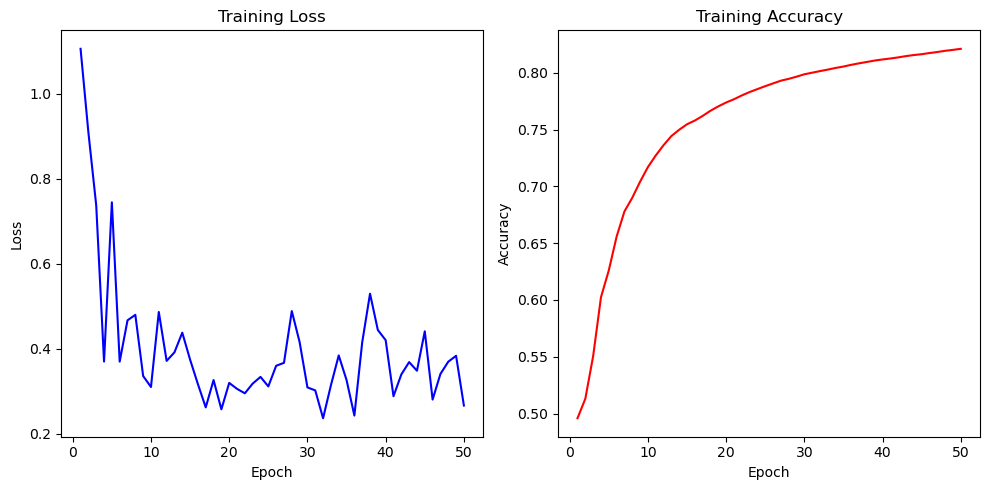

In [14]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))

# Plot loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), loss_values, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracy_values, 'r-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()

### Test accuracy

In [15]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track correct predictions and total samples
correct = 0
total = 0

# Disable gradient calculation during inference
with torch.no_grad():
    # Iterate over batches of data in the test loader
    for images, targets in test_loader:
        # Move input data and target labels to the appropriate device (GPU or CPU)
        images = images.to(device)
        targets = targets.to(device)
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        
        # Compute predicted labels by finding the maximum value along dimension 1
        _, predicted = torch.max(outputs, 1)
        
        # Update total sample count and correct prediction count
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

# Calculate test accuracy
test_accuracy = correct / total

# Print test accuracy
print(f'Test Accuracy: {test_accuracy:.2%}')


Test Accuracy: 83.95%
